In [88]:
import pandas as pd
import numpy as np
from matplotlib import pyplot

from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import anderson
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from scipy import stats

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.graphics.gofplots import qqplot

In [19]:
#import the data
nycdf = pd.read_csv("nyc-rolling-sales-dirty.csv")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [20]:
nycdf.head(5)

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392.0,No Number,,65000,NaN,...,5,0,5,1633,6440,1900,2,C2,6625000,why
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399.0,26,,C7,NaN,...,28,3,31,4616,18690,1900,2,C7,-,12/14/2016 0:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,NaN,399.0,39,,C7,NaN,...,16,1,17,2212,7803,1900,2,C7,-,12/9/2016 0:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,NaN,402.0,21,,C4,NaN,...,10,0,10,2272,6794,1913,2,C4,3936272,9/23/2016 0:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,NaN,404.0,55,,C2,NaN,...,6,0,6,2369,4615,1900,2,C2,8000000,11/17/2016 0:00


In [21]:
print("Rows=%d, Columns=%d" % (nycdf.shape[0], nycdf.shape[1]))
print(nycdf.dtypes)

Rows=84548, Columns=22
Unnamed: 0                          int64
BOROUGH                             int64
NEIGHBORHOOD                       object
BUILDING CLASS CATEGORY            object
TAX CLASS AT PRESENT               object
BLOCK                             float64
LOT                                object
EASE-MENT                          object
BUILDING CLASS AT PRESENT          object
ADDRESS                            object
APARTMENT NUMBER                   object
ZIP CODE                          float64
RESIDENTIAL UNITS                   int64
COMMERCIAL UNITS                    int64
TOTAL UNITS                         int64
LAND SQUARE FEET                   object
GROSS SQUARE FEET                  object
YEAR BUILT                          int64
TAX CLASS AT TIME OF SALE           int64
BUILDING CLASS AT TIME OF SALE     object
SALE PRICE                         object
SALE DATE                          object
dtype: object


In [23]:
# Dealing with incorrect values

# Lets see how many rows will be affected if we replace incorrect values with NaT
affected_date_records = pd.to_datetime(nycdf['SALE DATE'], errors='coerce').isnull().sum() - nycdf['SALE DATE'].isnull().sum()
print("Affected sale date records = %d" % affected_date_records)

# Same for year built
affected_year_built_records = pd.to_datetime(nycdf['YEAR BUILT'], errors='coerce').isnull().sum() - nycdf['YEAR BUILT'].isnull().sum()
print("Affected year built records = %d" % affected_year_built_records)

# Same for sale price
affected_sale_price_records = pd.to_datetime(nycdf['SALE PRICE'], errors='coerce').isnull().sum() - nycdf['SALE PRICE'].isnull().sum()
print("Affected sale price records = %d" % affected_sale_price_records)

Affected sale date records= 3
Affected year built records= 0
Affected sale price records= 84020


In [12]:
# Very few rows are being affected, so safe to replace
nycdf['SALE DATE'] = pd.to_datetime(nycdf['SALE DATE'], errors='coerce') # Replace incorrect values with NaT

nycdf['YEAR BUILT'] = pd.to_datetime(nycdf['YEAR BUILT'], errors='coerce') # Replace incorrect values with NaT

# Lets deal with incorrect Sales value in the same way for now
nycdf['SALE PRICE'] = pd.to_numeric(nycdf['SALE PRICE'], errors='coerce')

In [13]:
nycdf.dtypes

Unnamed: 0                                 int64
BOROUGH                                    int64
NEIGHBORHOOD                              object
BUILDING CLASS CATEGORY                   object
TAX CLASS AT PRESENT                      object
BLOCK                                    float64
LOT                                       object
EASE-MENT                                 object
BUILDING CLASS AT PRESENT                 object
ADDRESS                                   object
APARTMENT NUMBER                          object
ZIP CODE                                 float64
RESIDENTIAL UNITS                          int64
COMMERCIAL UNITS                           int64
TOTAL UNITS                                int64
LAND SQUARE FEET                          object
GROSS SQUARE FEET                         object
YEAR BUILT                        datetime64[ns]
TAX CLASS AT TIME OF SALE                  int64
BUILDING CLASS AT TIME OF SALE            object
SALE PRICE          

In [15]:
nycdf['SALE PRICE'].head(50)

0      6625000.0
1            NaN
2            NaN
3      3936272.0
4      8000000.0
5            NaN
6      3192840.0
7            NaN
8            NaN
9     16232000.0
10           NaN
11    10350000.0
12           1.0
13      499000.0
14          10.0
15      529500.0
16      423000.0
17      501000.0
18      450000.0
19      510000.0
20           NaN
21      350000.0
22    11900000.0
23    11900000.0
24      350000.0
25      404000.0
26      535000.0
27     1400000.0
28      866000.0
29      355000.0
30           NaN
31      805000.0
32      475000.0
33      450000.0
34      450000.0
35      810000.0
36           NaN
37      300000.0
38      300000.0
39      579000.0
40     1500000.0
41       25000.0
42      512000.0
43      410000.0
44      500000.0
45      510000.0
46      475000.0
47      789019.0
48           NaN
49           NaN
Name: SALE PRICE, dtype: float64

In [25]:
import re
def eliminate_numeric_values(item):
    if isinstance(item, str):
        return item if not re.match(r"^[0-9]+$", item) else pd.NaT
    else:
        return pd.NaT

# Customer Name values seems to be incorrect in some cases, they are just numbers, 
#lets replace incorrect values with NaN
nycdf['BUILDING CLASS AT PRESENT'] = nycdf['BUILDING CLASS AT PRESENT'].map(eliminate_numeric_values)

In [26]:
# missing values in our dataset
nycdf.isnull().sum()

Unnamed: 0                         0
BOROUGH                            0
NEIGHBORHOOD                      30
BUILDING CLASS CATEGORY           51
TAX CLASS AT PRESENT               7
BLOCK                             16
LOT                                0
EASE-MENT                          0
BUILDING CLASS AT PRESENT          1
ADDRESS                           45
APARTMENT NUMBER                   1
ZIP CODE                          36
RESIDENTIAL UNITS                  0
COMMERCIAL UNITS                   0
TOTAL UNITS                        0
LAND SQUARE FEET                   0
GROSS SQUARE FEET                  0
YEAR BUILT                         0
TAX CLASS AT TIME OF SALE          0
BUILDING CLASS AT TIME OF SALE     0
SALE PRICE                         0
SALE DATE                          0
dtype: int64

In [30]:
# building class seems to have alot of null values
#and it cannot be used as unique identifier for our records
print(nycdf['BUILDING CLASS CATEGORY'].is_unique)

False


In [31]:
# so there is no real significance of keeping building class,
# Lets drop this column
nycdf = nycdf.drop('BUILDING CLASS CATEGORY', axis=1)

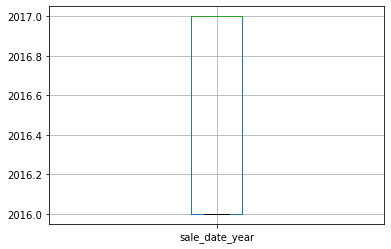

In [46]:
#create a separate column for the year and see boxplot
nycdf['sale_date_year'] = pd.to_datetime(nycdf['SALE DATE'], errors='coerce').apply(lambda x: x.year)
nycdf.boxplot(column='sale_date_year', sym='o', return_type='axes')


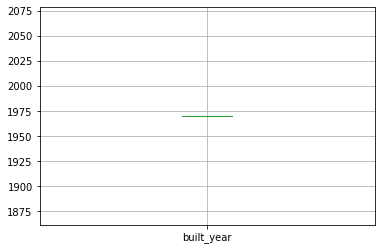

In [47]:
#create a separate column for the year and see boxplot
nycdf['built_year'] = pd.to_datetime(nycdf['YEAR BUILT'], errors='coerce').apply(lambda x: x.year)
nycdf.boxplot(column='built_year', sym='o', return_type='axes')

In [48]:
nycdf = nycdf.drop('sale_date_year', axis=1)
nycdf = nycdf.drop('built_year', axis=1)

In [49]:
nycdf = nycdf[(nycdf['SALE PRICE'].isna() & nycdf['SALE DATE'].isna()) == False]
nycdf

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,2A,392.0,No Number,,NaT,NaN,NaN,...,5,0,5,1633,6440,1900,2,C2,6625000,why
1,5,1,ALPHABET CITY,2,399.0,26,,C7,NaN,,...,28,3,31,4616,18690,1900,2,C7,-,12/14/2016 0:00
2,6,1,ALPHABET CITY,NaN,399.0,39,,C7,NaN,,...,16,1,17,2212,7803,1900,2,C7,-,12/9/2016 0:00
3,7,1,ALPHABET CITY,NaN,402.0,21,,C4,NaN,,...,10,0,10,2272,6794,1913,2,C4,3936272,9/23/2016 0:00
4,8,1,ALPHABET CITY,NaN,404.0,55,,C2,NaN,,...,6,0,6,2369,4615,1900,2,C2,8000000,11/17/2016 0:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84543,8409,5,WOODROW,1,7349.0,34,,B9,37 QUAIL LANE,,...,2,0,2,2400,2575,1998,1,B9,450000,11/28/2016 0:00
84544,8410,5,WOODROW,1,7349.0,78,,B9,32 PHEASANT LANE,,...,2,0,2,2498,2377,1998,1,B9,550000,4/21/2017 0:00
84545,8411,5,WOODROW,1,7351.0,60,,B2,49 PITNEY AVENUE,,...,2,0,2,4000,1496,1925,1,B2,460000,7/5/2017 0:00
84546,8412,5,WOODROW,4,7100.0,28,,K6,2730 ARTHUR KILL ROAD,,...,0,7,7,208033,64117,2001,4,K6,11693337,12/21/2016 0:00


In [52]:
nycdf = nycdf.drop(nycdf[(nycdf['SALE DATE'].isnull()) & (nycdf['YEAR BUILT'].isnull())].index)

FLUSHING-NORTH              3068
UPPER EAST SIDE (59-79)     1736
UPPER EAST SIDE (79-96)     1590
UPPER WEST SIDE (59-79)     1439
BEDFORD STUYVESANT          1436
                            ... 
FRESH KILLS                    2
PELHAM BAY                     1
BRONX PARK                     1
CITY ISLAND-PELHAM STRIP       1
EAST RIVER                     1
Name: NEIGHBORHOOD, Length: 254, dtype: int64


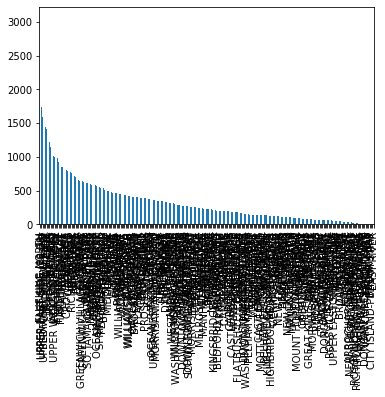

In [53]:
# For neighbourhood
print(nycdf['NEIGHBORHOOD'].value_counts())
nycdf['NEIGHBORHOOD'].value_counts().plot(kind='bar')

4    26736
3    24047
1    18306
5     8410
2     7049
Name: BOROUGH, dtype: int64


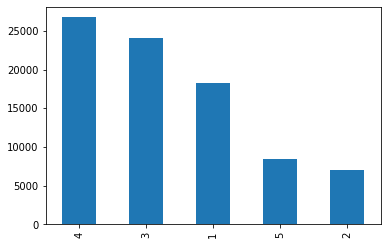

In [54]:
# For BOROUGH
print(nycdf['BOROUGH'].value_counts())
nycdf['BOROUGH'].value_counts().plot(kind='bar')

1      34722
0      24783
2      16049
3       4608
4       1346
       ...  
164        1
420        1
165        1
550        1
283        1
Name: RESIDENTIAL UNITS, Length: 176, dtype: int64


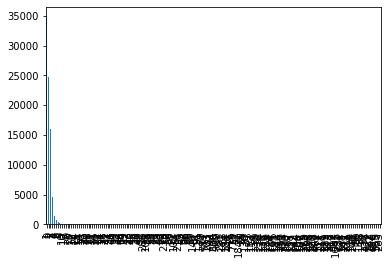

In [56]:

# For RESIDENTIAL UNITS
print(nycdf['RESIDENTIAL UNITS'].value_counts())
nycdf['RESIDENTIAL UNITS'].value_counts().plot(kind='bar')

0       79429
1        3558
2         817
3         259
4         137
5          74
6          70
7          31
8          26
9          20
10         17
12         12
15         11
11         10
17          6
14          6
254         4
13          4
35          4
20          4
19          3
42          3
22          3
18          3
422         2
436         2
26          2
25          2
16          2
126         2
73          1
67          1
318         1
147         1
2261        1
62          1
59          1
184         1
56          1
55          1
52          1
51          1
49          1
172         1
38          1
34          1
32          1
31          1
30          1
28          1
91          1
27          1
24          1
21          1
23          1
Name: COMMERCIAL UNITS, dtype: int64


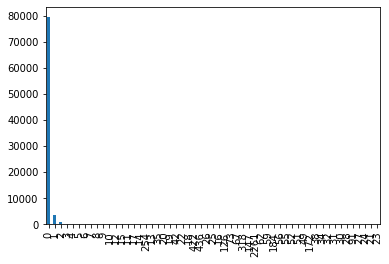

In [58]:
# For COMMERCIAL UNITS
print(nycdf['COMMERCIAL UNITS'].value_counts())
nycdf['COMMERCIAL UNITS'].value_counts().plot(kind='bar')

In [59]:
nycdf = nycdf.drop('COMMERCIAL UNITS', axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


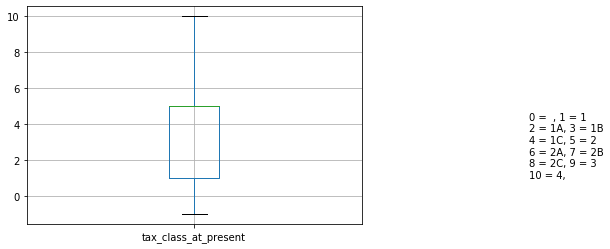

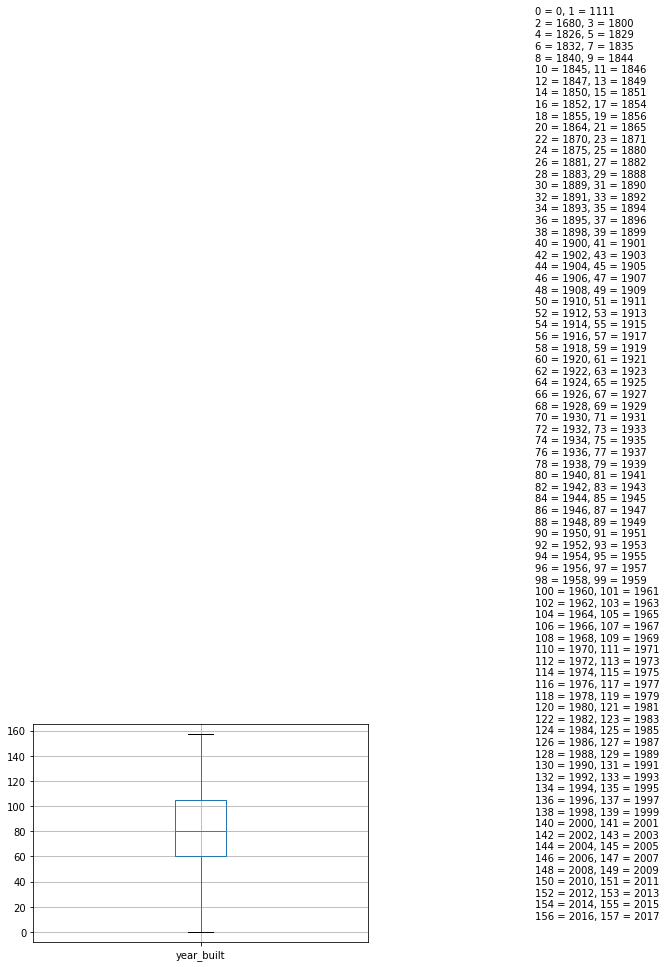

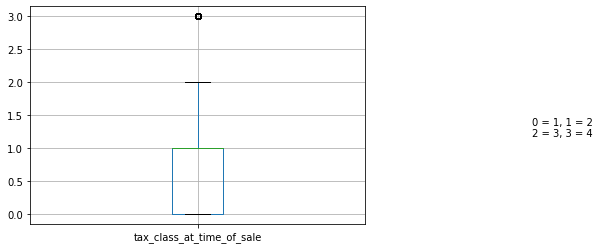

In [68]:
# convert all columns holding categorical data to pandas category type

# Lets pick categorical columns in a separate dataframe to be on safe side
nycdf_cat = nycdf[['TAX CLASS AT PRESENT', 'YEAR BUILT', 'TAX CLASS AT TIME OF SALE']]


mapper = {}

for i in nycdf_cat.columns:
    nycdf_cat[i] = nycdf_cat[i].astype('category')
    k = i.lower().replace(' ', '_')
    
    # Save map to use later for better understanding
    d = dict(enumerate(nycdf_cat[i].cat.categories))
    mapper[k] = d
    nycdf_cat[k] = nycdf_cat[i].cat.codes
    nycdf_cat = nycdf_cat.drop(i, axis=1)

import matplotlib.pyplot as plt    

for i in nycdf_cat.columns:
    text_to_display = ""
    count = 0
    for k,v in mapper[i].items():
        count += 1
        text_to_display += "%s = %s"%(str(k),v)
        if count%2 == 0:
            text_to_display += "\n"
        else:
            text_to_display += ", "
    fig = plt.figure()
    plt.text(2, 1, text_to_display)
    nycdf_cat.boxplot(column=i, sym='o', return_type='axes')


In [82]:
pd.to_numeric(nycdf['SALE PRICE'],errors='coerce').mean()

1276456.4977638705

In [83]:
nycdf.dtypes

Unnamed: 0                          int64
BOROUGH                             int64
NEIGHBORHOOD                       object
TAX CLASS AT PRESENT               object
BLOCK                             float64
LOT                                object
EASE-MENT                          object
BUILDING CLASS AT PRESENT          object
ADDRESS                            object
APARTMENT NUMBER                   object
ZIP CODE                          float64
RESIDENTIAL UNITS                   int64
TOTAL UNITS                         int64
LAND SQUARE FEET                   object
GROSS SQUARE FEET                  object
YEAR BUILT                          int64
TAX CLASS AT TIME OF SALE           int64
BUILDING CLASS AT TIME OF SALE     object
SALE PRICE                         object
SALE DATE                          object
dtype: object

In [95]:
t_val, p_val = stats.ttest_ind(pd.to_numeric(nycdf['SALE PRICE'],errors='coerce'), pd.to_numeric(nycdf['SALE PRICE'],errors='coerce'))
print('t-value=%s' % str(t_val))

t-value=nan


# T-Test

In [89]:
# T-Test
types_map = nycdf.dtypes.to_dict()
num_columns = []
for k,v in types_map.items():
    if np.issubdtype(np.int64, v) or np.issubdtype(np.float64, v):
        num_columns.append(k)

print(num_columns)

for i in range(len(num_columns)-1):
    for j in range(i+1,len(num_columns)):
        col1 = num_columns[i]
        col2 = num_columns[j]
        t_val, p_val = stats.ttest_ind(nycdf[col1], nycdf[col2])
        print("(%s,%s) => t-value=%s, p-value=%s" % (num_columns[i], num_columns[j], str(t_val), str(p_val)))

['Unnamed: 0', 'BOROUGH', 'BLOCK', 'ZIP CODE', 'RESIDENTIAL UNITS', 'TOTAL UNITS', 'YEAR BUILT', 'TAX CLASS AT TIME OF SALE']
(Unnamed: 0,BOROUGH) => t-value=420.4508686562742, p-value=0.0
(Unnamed: 0,BLOCK) => t-value=nan, p-value=nan
(Unnamed: 0,ZIP CODE) => t-value=nan, p-value=nan
(Unnamed: 0,RESIDENTIAL UNITS) => t-value=420.48930578508714, p-value=0.0
(Unnamed: 0,TOTAL UNITS) => t-value=420.4798715059521, p-value=0.0
(Unnamed: 0,YEAR BUILT) => t-value=346.8462912797462, p-value=0.0
(Unnamed: 0,TAX CLASS AT TIME OF SALE) => t-value=420.50540517444216, p-value=0.0
(BOROUGH,BLOCK) => t-value=nan, p-value=nan
(BOROUGH,ZIP CODE) => t-value=nan, p-value=nan
(BOROUGH,RESIDENTIAL UNITS) => t-value=16.878494755154488, p-value=7.308498467764613e-64
(BOROUGH,TOTAL UNITS) => t-value=11.461423757872115, p-value=2.1150352048246938e-30
(BOROUGH,YEAR BUILT) => t-value=-966.6238304439144, p-value=0.0
(BOROUGH,TAX CLASS AT TIME OF SALE) => t-value=255.23305079874913, p-value=0.0
(BLOCK,ZIP CODE) =

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Conducted t-test for between all numeric columns in our dataset and as shown in the results above all p-value for every pair turns out to be less than 0.05 (p-val < 0.05), infact its very small for every pair. Thus, there is a statistically significant difference between all above mentioned numeric columns


# Annova 1

In [111]:
categorical = list((set(nycdf.columns) - set(num_columns)) - set(['SALE DATE', 'YEAR BUILT']))
print(categorical)
print(num_columns)

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Taking 1-way anova of Sale with all categorical variables
for i in categorical:
    nycdf['Sale'] = pd.to_numeric(nycdf['SALE PRICE'],errors='coerce')
    model = ols('Sale ~ C(Q("%s"))'% i, data=nycdf).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print ("\nAnova => Sale - %s" % i)
    display(anova_table)


['BUILDING CLASS AT TIME OF SALE', 'LOT', 'EASE-MENT', 'TAX CLASS AT PRESENT', 'BUILDING CLASS AT PRESENT', 'LAND SQUARE FEET', 'NEIGHBORHOOD', 'ADDRESS', 'SALE PRICE', 'APARTMENT NUMBER', 'GROSS SQUARE FEET']
['Unnamed: 0', 'BOROUGH', 'BLOCK', 'ZIP CODE', 'RESIDENTIAL UNITS', 'TOTAL UNITS', 'YEAR BUILT', 'TAX CLASS AT TIME OF SALE']

Anova => Sale - BUILDING CLASS AT TIME OF SALE


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 165, but rank is 160
  'rank is %d' % (J, J_), ValueWarning)


,sum_sq,df,F,PR(>F)
"C(Q(""BUILDING CLASS AT TIME OF SALE""))",2.866890e+18,165.0,191.853291,0.0
Residual,6.323754e+18,69826.0,NaN,NaN


ValueError: mismatch between column_names and columns coded by given terms

# Q1. How many 1 to 3 family homes were sold in each neighborhood?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027FE15EF188>]],
      dtype=object)

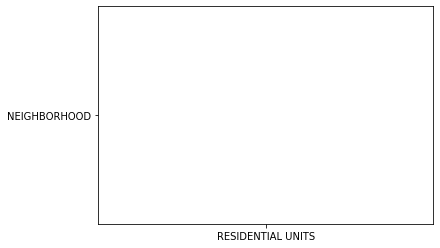

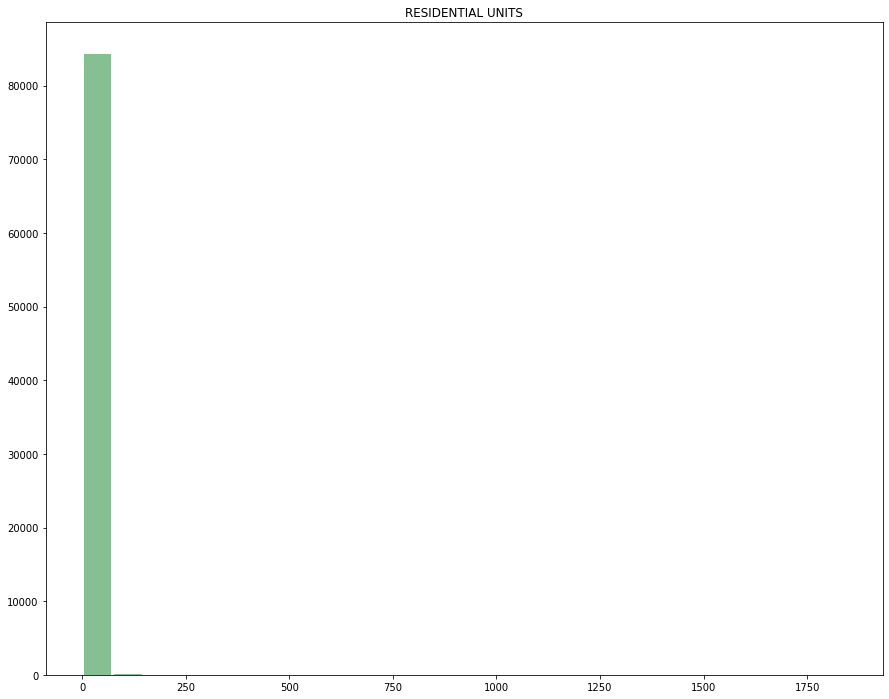

In [131]:
import matplotlib.pyplot as plt

# # An "interface" to matplotlib.axes.Axes.hist() method
# n, bins, patches = plt.hist(x=d, bins='auto', color='#0504aa',
#                             alpha=0.7, rwidth=0.85)
# plt.grid(axis='y', alpha=0.75)
# plt.xlabel('RESIDENTIAL UNITS by NEIGHBORHOOD')
# plt.ylabel('NEIGHBORHOOD')
# plt.title('My Very Own Histogram')
# plt.text(23, 45, r'$\mu=15, b=3$')
# maxfreq = n.max()
# # Set a clean upper y-axis limit.
# plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.bar('RESIDENTIAL UNITS', 'NEIGHBORHOOD')
nycdf.hist(column=['RESIDENTIAL UNITS', 'NEIGHBORHOOD'],
            bins=25, grid=False, figsize=(15,12), color='#86bf91', zorder=2, rwidth=0.9)

i was trying to draw a bar chart of residential units vs neighbor hood as i did it on data studio and saw  that the vast majority of 1-3 family homes are in the more affluent neighborhoods of New York City. Case in point, the Upper West Side of Manhattan had sold approximately 670 properties in 2017 all of which were 1-3 family homes. but i was not able to draw it in python.

# Q2. For any property sold for over $1,000,000, when did the building boom associated with it occur?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027FE1A23688>]],
      dtype=object)

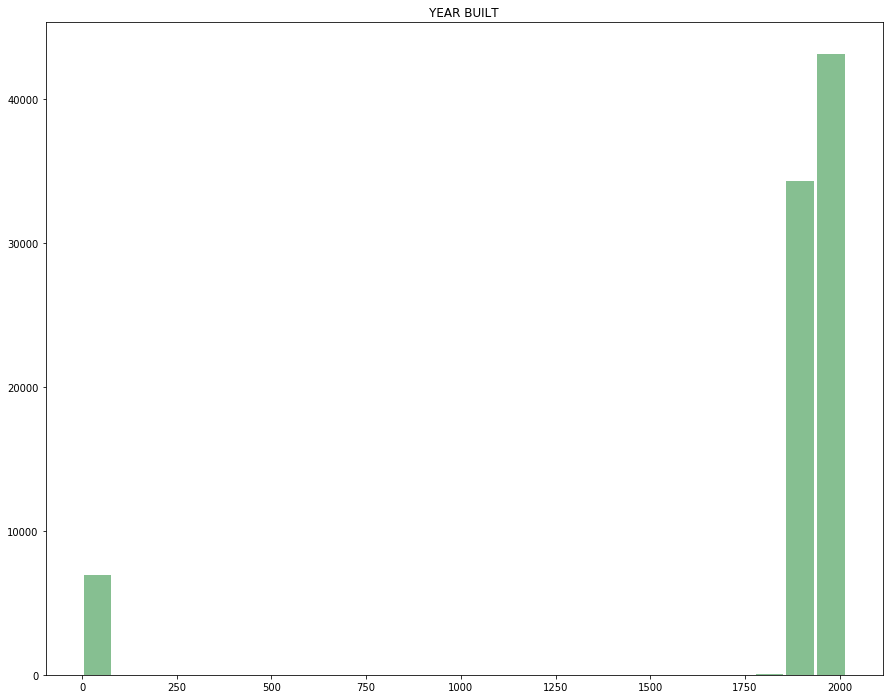

In [133]:
nycdf.hist(column=['YEAR BUILT', 'SALE DATE', 'SALE PRICE'],
            bins=25, grid=False, figsize=(15,12), color='#86bf91', zorder=2, rwidth=0.9)

In [140]:
nycdf.hist(column=[pd.to_numeric(nycdf['SALE PRICE'],errors='coerce')],
            bins=25, grid=False, figsize=(15,12), color='#86bf91', zorder=2, rwidth=0.9)

KeyError: "None of [Index([(6625000.0, nan, nan, 3936272.0, 8000000.0, nan, 3192840.0, nan, nan, 16232000.0, nan, 10350000.0, 1.0, 499000.0, 10.0, 529500.0, 423000.0, 501000.0, 450000.0, 510000.0, nan, 350000.0, 11900000.0, 11900000.0, 350000.0, 404000.0, 535000.0, 1400000.0, 866000.0, 355000.0, nan, 805000.0, 475000.0, 450000.0, 450000.0, 810000.0, nan, 300000.0, 300000.0, 579000.0, 1500000.0, 25000.0, 512000.0, 410000.0, 500000.0, 510000.0, 475000.0, 789019.0, nan, nan, 425000.0, 490000.0, 409000.0, 415000.0, 420000.0, 435000.0, 575000.0, 605000.0, 799000.0, 800000.0, 54993.0, 410000.0, 1475000.0, 335000.0, 490000.0, 750000.0, 780000.0, 2400000.0, 380000.0, 430000.0, 499900.0, 1400000.0, 694000.0, 28000000.0, 8058923.0, 52625000.0, 620000.0, nan, nan, 762669.0, 772851.0, 1034880.0, nan, nan, nan, 800000.0, 2295759.0, 875000.0, nan, nan, nan, nan, nan, nan, nan, 701341.0, nan, nan, nan, nan, ...)], dtype='object')] are in the [columns]"

Here again i did in data studio and saw that a great number of properties sold at a value exceeding $1,000,000 were built at the the 20th and the 21st centuries. 
but i was not able to draw the histogram again

# Q3. What is the average square footage sold to each tax class?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027F850E7D48>]],
      dtype=object)

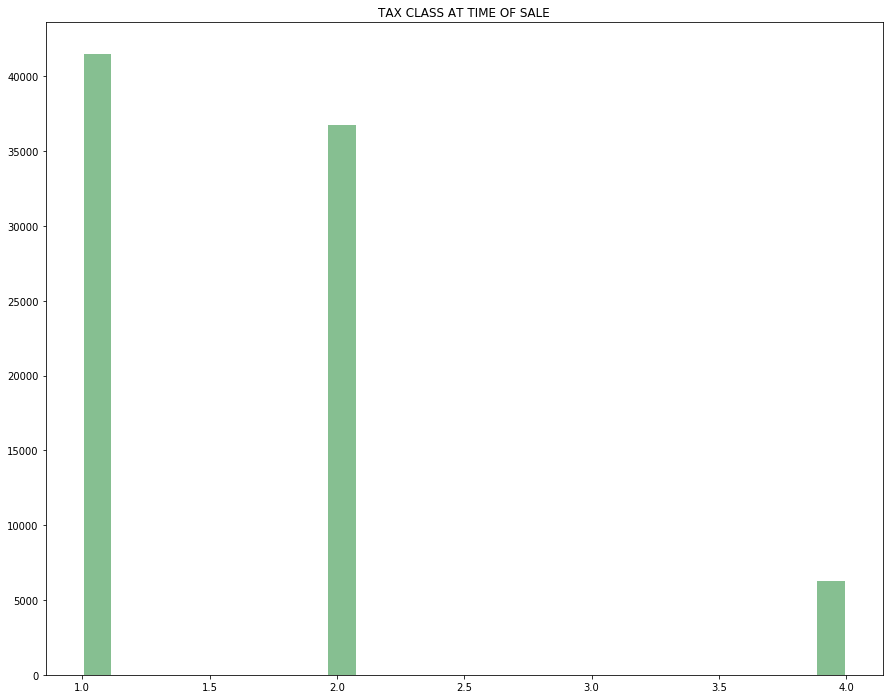

In [142]:

nycdf.hist(column=['GROSS SQUARE FEET', 'TAX CLASS AT TIME OF SALE'],
            bins=25, grid=False, figsize=(15,12), color='#86bf91', zorder=2, rwidth=0.9)

In [138]:
nycdf.dtypes

Unnamed: 0                          int64
BOROUGH                             int64
NEIGHBORHOOD                       object
TAX CLASS AT PRESENT               object
BLOCK                             float64
LOT                                object
EASE-MENT                          object
BUILDING CLASS AT PRESENT          object
ADDRESS                            object
APARTMENT NUMBER                   object
ZIP CODE                          float64
RESIDENTIAL UNITS                   int64
TOTAL UNITS                         int64
LAND SQUARE FEET                   object
GROSS SQUARE FEET                  object
YEAR BUILT                          int64
TAX CLASS AT TIME OF SALE           int64
BUILDING CLASS AT TIME OF SALE     object
SALE PRICE                         object
SALE DATE                          object
Sale                              float64
dtype: object

Class 1, residential homes of 1-3 families have on average the lowest gross square footage in Manhattan, contrary to class 4 which includes offices, factories and warehouses. class 2 properties which include primarily residential properties such as apartment buildings constitute approximately 38% of the total properties sold in Manhattan. This information can be very useful to any real estate agent, buyer or seller of properties in NYC. 
again i was unable to draw in python but did in data studio and hence wrote the observation